In [25]:
import numpy as np
import json
import os
import pickle
import re
import xrt.backends.raycing.sources as rsources

import params

%matplotlib inline
import matplotlib

matplotlib.use("pgf")

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
        r"\usepackage[T2A]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english,russian]{babel}",
    ]),
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.figsize': [4.75, 4.75 * 9 / 16],
    'figure.dpi': 200
})

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator, LinearLocator, MaxNLocator
from utils.various import datafiles
from utils.xrtutils import get_integral_breadth, bell_fit



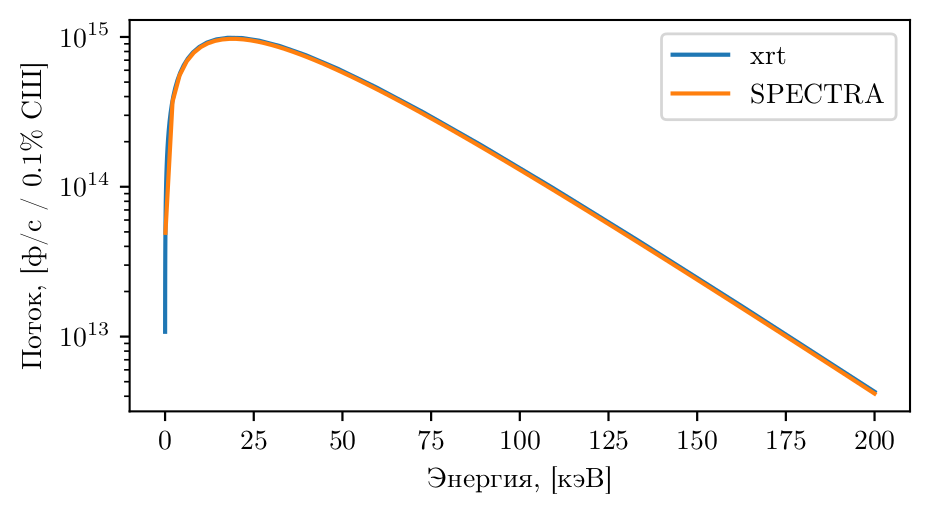

In [2]:
energy = np.logspace(1, 5 + np.log10(2.), 50)

bl = '1_5'
md = getattr(params, 'params_' + bl)
wiggler_kwargs = getattr(params.sources, 'wiggler_' + bl + '_kwargs')

theta = np.linspace(-md.front_end_h_angle, md.front_end_h_angle, 100) / 2.
psi = np.linspace(-md.front_end_v_angle, md.front_end_v_angle, 50) / 2.

source = rsources.Wiggler(
    eMin=energy[0],
    eMax=energy[-1],
    distE='BW',
    xPrimeMax=theta[-1] * 1e3,
    zPrimeMax=psi[-1] * 1e3,
    **params.sources.ring_kwargs,
    **wiggler_kwargs
)

I0, l1, l2, l3 = source.intensities_on_mesh(energy, theta, psi)

dtheta, dpsi = theta[1] - theta[0], psi[1] - psi[0]
flux = I0.sum(axis=(1, 2)) * dtheta * dpsi

data = json.load(open('dcd_paper_1_figs/12.json', 'r'))
data = data['Output']['data']


fig = plt.figure(bl)
plt.semilogy(energy * 1e-3, flux, label='xrt')
plt.semilogy(np.array(data[0]) * 1e-3, data[1], label='SPECTRA')
plt.xlabel('Энергия, [кэВ]')
plt.ylabel('Поток, [ф/с / 0.1% СШ]')
plt.legend()
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/source.pgf')
fig


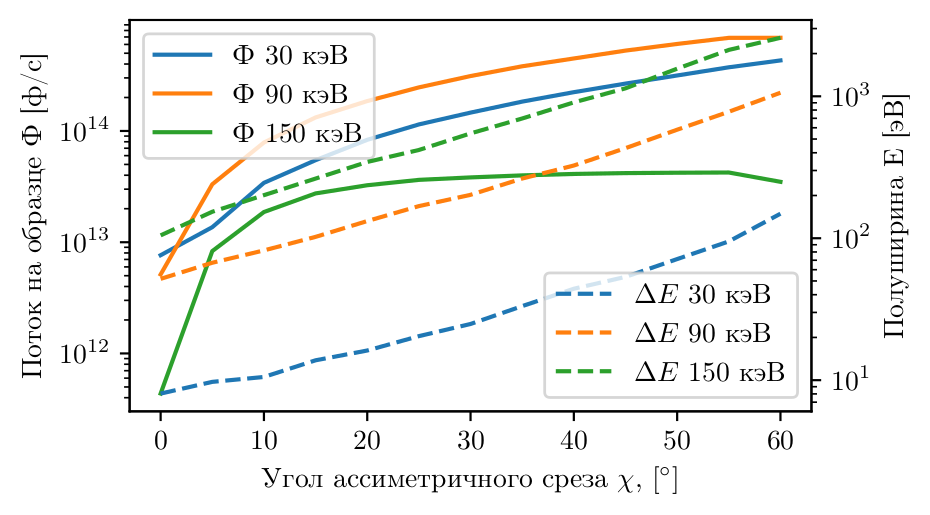

In [3]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'chi_scan')

flux, flux2, ebr, ebr2, alpha, en = [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    alpha.append(metadata['alpha'])
    en.append(metadata['energy'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, alpha, en = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), np.array(alpha), np.array(en)

en_values = sorted(set(en))

plt.close(fig)
fig = plt.figure()
ax = fig.subplots()
ax2 = ax.twinx()

for en_v in en_values:
    ii = (en == en_v)
    flux_, flux2_, ebr_, ebr2_, alpha_, en_ = flux[ii], flux2[ii], ebr[ii], ebr2[ii], alpha[ii], en[ii]

    ii = np.argsort(alpha_)
    flux_, flux2_, ebr_, ebr2_, alpha_, en_ = flux_[ii], flux2_[ii], ebr_[ii], ebr2_[ii], alpha_[ii], en_[ii]
    
    ax.semilogy(alpha_, flux2_, label='Ф %d кэВ' % int(en_v))
    ax2.semilogy(alpha_, ebr2_ , '--', label='$\Delta E$ %d кэВ' % int(en_v))


ax.set_xlabel('Угол ассиметричного среза $\chi$, $[^{\circ}]$')
ax.set_ylabel('Поток на образце Ф [ф/с]')
ax.legend(loc='upper left')

ax2.set_ylabel('Полуширина E [эВ]')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('dcd_paper_1_figs/chi_flux_ebr.pgf')
fig

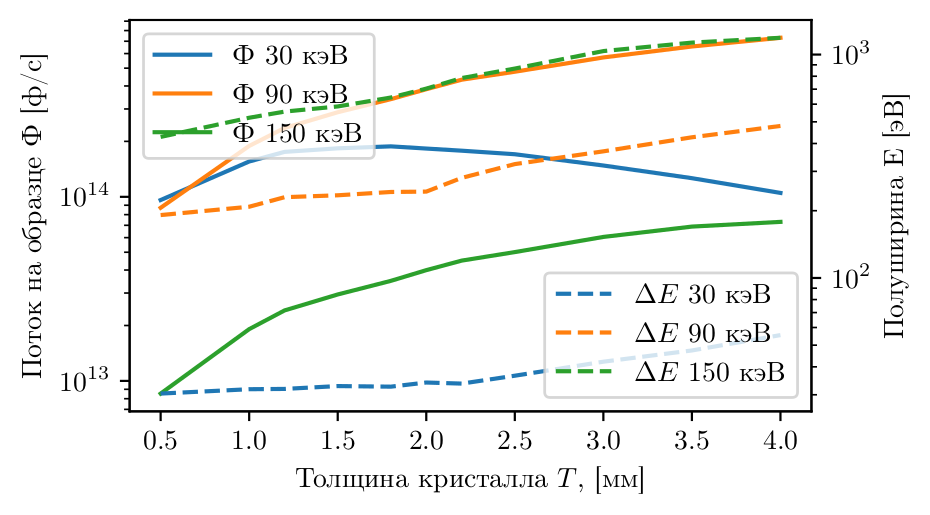

In [4]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 't_scan')

flux, flux2, ebr, ebr2, t, en = [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    t.append(metadata['thickness'])
    en.append(metadata['energy'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, t, en = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), np.array(t), np.array(en)

en_values = sorted(set(en))

plt.close(fig)
fig = plt.figure()
ax = fig.subplots()
ax2 = ax.twinx()

for en_v in en_values:
    ii = (en == en_v)
    flux_, flux2_, ebr_, ebr2_, t_, en_ = flux[ii], flux2[ii], ebr[ii], ebr2[ii], t[ii], en[ii]

    ii = np.argsort(t_)
    flux_, flux2_, ebr_, ebr2_, t_, en_ = flux_[ii], flux2_[ii], ebr_[ii], ebr2_[ii], t_[ii], en_[ii]
    
    ax.semilogy(t_, flux2_, label='Ф %d кэВ' % int(en_v))
    ax2.semilogy(t_, ebr2_ , '--', label='$\Delta E$ %d кэВ' % int(en_v))


ax.set_xlabel('Толщина кристалла $T$, [мм]')
ax.set_ylabel('Поток на образце Ф [ф/с]')
ax.legend(loc='upper left')

ax2.set_ylabel('Полуширина E [эВ]')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('dcd_paper_1_figs/t_flux_ebr.pgf')
fig

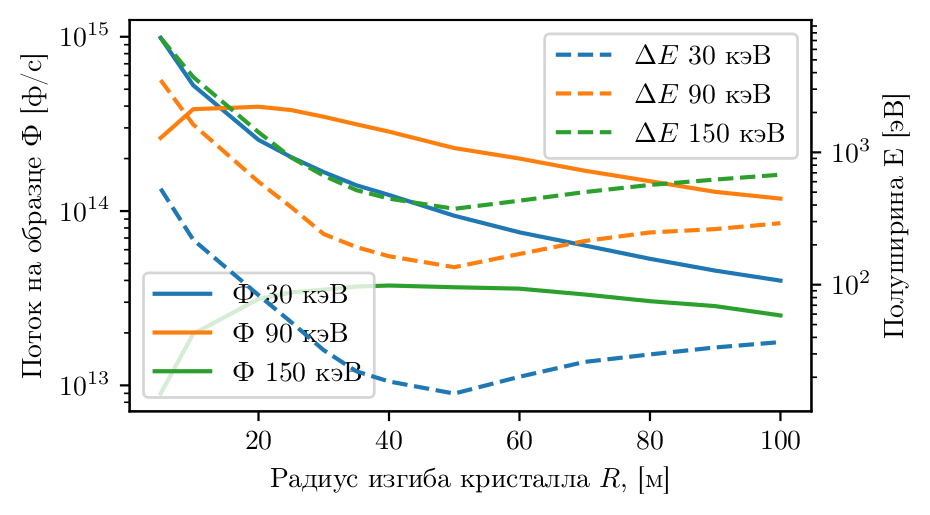

In [5]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'r_scan')

flux, flux2, ebr, ebr2, r, en = [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r.append(metadata['r1'])
    en.append(metadata['energy'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r, en = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), np.array(r), np.array(en)

en_values = sorted(set(en))

plt.close(fig)
fig = plt.figure()
ax = fig.subplots()
ax2 = ax.twinx()

for en_v in en_values:
    ii = (en == en_v)
    flux_, flux2_, ebr_, ebr2_, r_, en_ = flux[ii], flux2[ii], ebr[ii], ebr2[ii], r[ii], en[ii]

    ii = np.argsort(r_)
    flux_, flux2_, ebr_, ebr2_, r_, en_ = flux_[ii], flux2_[ii], ebr_[ii], ebr2_[ii], r_[ii], en_[ii]
    
    ax.semilogy(r_, flux2_, label='Ф %d кэВ' % int(en_v))
    ax2.semilogy(r_, ebr2_ , '--', label='$\Delta E$ %d кэВ' % int(en_v))


ax.set_xlabel('Радиус изгиба кристалла $R$, [м]')
ax.set_ylabel('Поток на образце Ф [ф/с]')
ax.legend(loc='lower left')

ax2.set_ylabel('Полуширина E [эВ]')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('dcd_paper_1_figs/r_flux_ebr.pgf')
fig

30.0 5.0 11
30.0 10.0 11
30.0 20.0 11
30.0 30.0 11
30.0 40.0 11
30.0 50.0 11
90.0 5.0 21
90.0 10.0 21
90.0 20.0 21
90.0 30.0 21
90.0 40.0 11
90.0 50.0 21
150.0 5.0 21
150.0 10.0 21
150.0 20.0 21
150.0 30.0 21
150.0 40.0 11
150.0 50.0 21


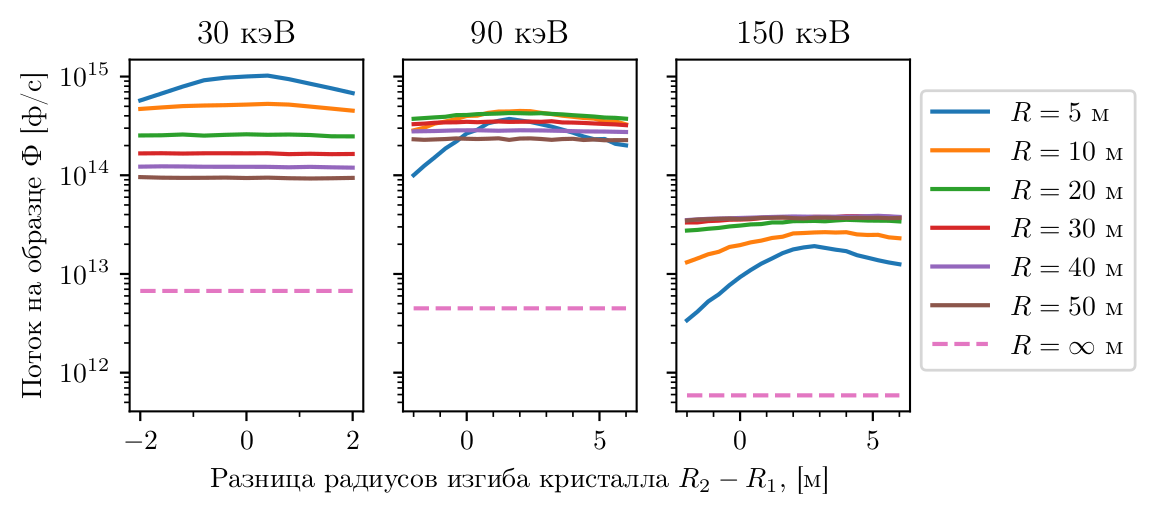

In [6]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'r_map')

flux, flux2, ebr, ebr2, r1, r2, en = [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), np.array(r1), np.array(r2), np.array(en)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
r1_values.remove(np.inf)

plt.close(fig)
fig, axes = plt.subplots(1, 3, sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    dr_min, dr_max = 0., 0., 
    
    for r1_v in r1_values:
        ii = (en == en_v)
        flux_, flux2_, ebr_, ebr2_, r1_, r2_, en_ = flux[ii], flux2[ii], ebr[ii], ebr2[ii], r1[ii], r2[ii], en[ii]
        
        ii = (r1_ == r1_v)
        flux_, flux2_, ebr_, ebr2_, r1_, r2_, en_ = flux_[ii], flux2_[ii], ebr_[ii], ebr2_[ii], r1_[ii], r2_[ii], en_[ii]
        
        if flux_.size == 0:
            continue
        else:
            print(en_v, r1_v, flux_.size)

        ii = np.argsort(r2_)
        flux_, flux2_, ebr_, ebr2_, r1_, r2_, en_ = flux_[ii], flux2_[ii], ebr_[ii], ebr2_[ii], r1_[ii], r2_[ii], en_[ii]
        
        lbl = '$R=%d$ м' % int(r1_v)
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(r2_ - r1_, flux2_, label=lbl)
        
        dr_min, dr_max = min(dr_min, min(r2_ - r1_)), max(dr_max, max(r2_ - r1_))
    
    ii = (en == en_v) & np.isinf(r1) & np.isinf(r2)
    lbl = '$R=\infty$ м'
    if en_v != en_values[0]:
        lbl = '_' + lbl
    ax.semilogy([dr_min, dr_max], [flux2[ii].mean(), flux2[ii].mean()], '--', label=lbl)
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel('Разница радиусов изгиба кристалла $R_2 - R_1$, [м]')
    
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
# fig.legend(loc='lower center')
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/r1r2_flux.pgf')
fig

[30.0, 90.0, 150.0] [20.0, inf]


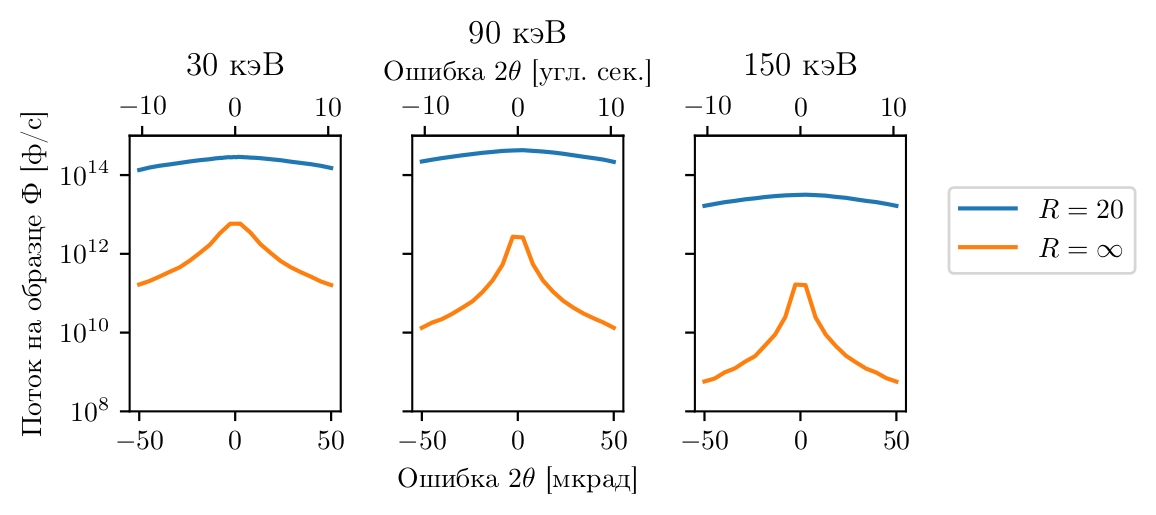

In [7]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'tth_offset_scan')

flux, flux2, ebr, ebr2, r1, r2, en, dtth = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dtth.append(metadata['tth_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dtth = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dtth)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dtth_ = flux2[ii], dtth[ii]
        ii = np.argsort(dtth_)
        flux2_, dtth_ = flux2_[ii], dtth_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(np.radians(dtth_) * 1e6, flux2_, label=lbl)
        
    secax = ax.secondary_xaxis('top', functions=(lambda x: 1e-6 * x * 180 * 3600 / np.pi, lambda x: 1e6 * x  * np.pi / (180 * 3600)))
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $2\theta$ [мкрад]')
        secax.set_xlabel(r'Ошибка $2\theta$ [угл. сек.]')

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/tth-offset.pgf')
fig

[30.0, 90.0, 150.0] [20.0, inf]


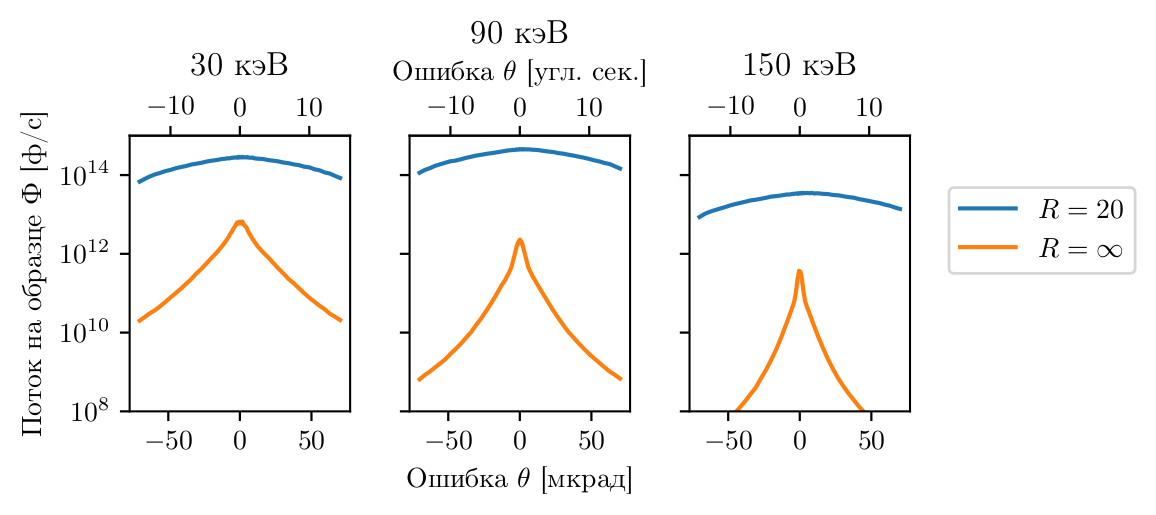

In [8]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'tth_offset_scan2')

flux, flux2, ebr, ebr2, r1, r2, en, dtth = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dtth.append(metadata['tth_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dtth = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dtth)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dtth_ = flux2[ii], dtth[ii]
        ii = np.argsort(dtth_)
        flux2_, dtth_ = flux2_[ii], dtth_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(np.radians(dtth_ / 3600.) * 1e6, flux2_, label=lbl)
        
        if (en_v == 150) & np.isinf(r_v):
            xx, yy = np.radians(dtth_ / 3600.) * 1e6, flux2_
        
    secax = ax.secondary_xaxis('top', functions=(lambda x: 1e-6 * x * 180 * 3600 / np.pi, lambda x: 1e6 * x  * np.pi / (180 * 3600)))
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $\theta$ [мкрад]')
        secax.set_xlabel(r'Ошибка $\theta$ [угл. сек.]')

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/tth-offset2.pgf')
fig

FWHM = 3.7 μrad = 0.8 arcsec


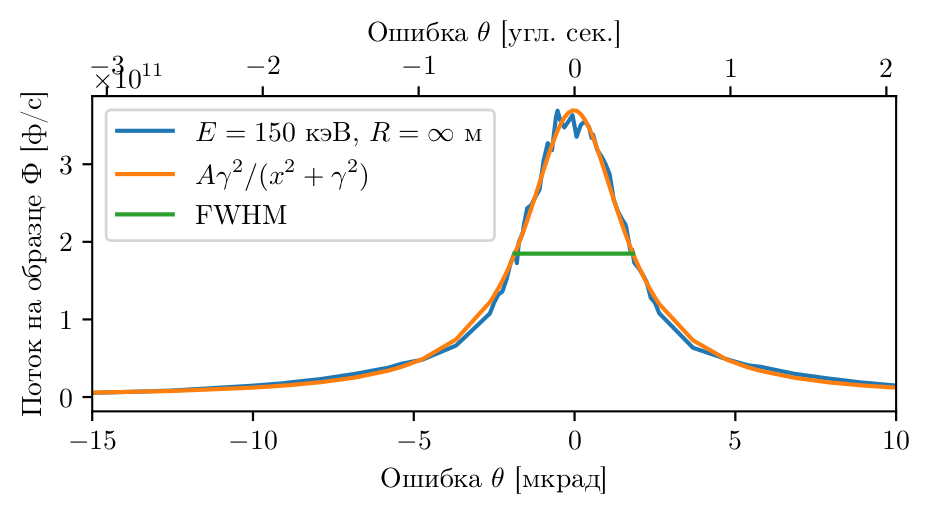

In [9]:
plt.close(fig)
fig, axes = plt.subplots()
axes.plot(xx, yy, label=r'$E = 150$ кэВ, $R = \infty$ м')

popt, _ = bell_fit(xx, yy, fn='lorentz')

axes.plot(xx, bell_fit.f(xx, *popt), label=r'$A \gamma^2 / (x^2 +\gamma^2)$')
axes.plot([popt[0] - popt[1], popt[0] + popt[1]], [.5 * popt[2], .5 * popt[2]], 
          label='FWHM')
axes.set_xlim(-15, 10)

secax = axes.secondary_xaxis('top', functions=(lambda x: 1e-6 * x * 180 * 3600 / np.pi, lambda x: 1e6 * x  * np.pi / (180 * 3600)))
axes.set_xlabel(r'Ошибка $\theta$ [мкрад]')
secax.set_xlabel(r'Ошибка $\theta$ [угл. сек.]')
axes.set_ylabel('Поток на образце Ф [ф/с]')

print('FWHM = %.01f μrad = %.01f arcsec' % (2. * popt[1], np.degrees(2. * popt[1] * 1e-6) * 3600.))

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/tth-offset-fit.pgf')

fig

/Users/glebdovzhenko/Yandex.Disk.localized/Dev/skif-xrt/utils/xrtutils.py:122: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum((.5 * t1d[1:] + .5 * t1d[:-1]) * (bins[1:] - bins[:-1])) / np.max(t1d)


[30.0, 90.0, 150.0] [20.0, inf]


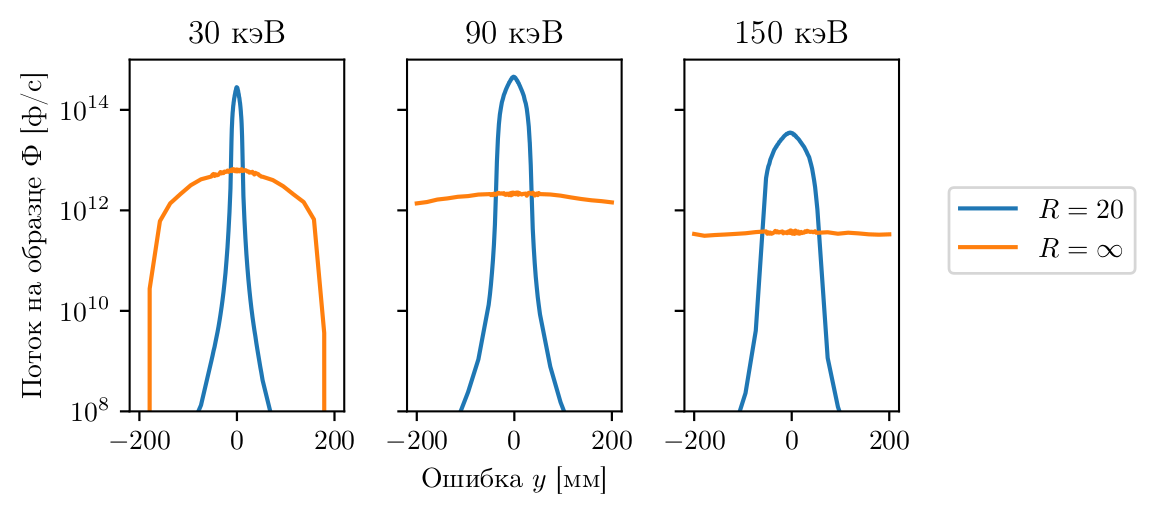

In [10]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'y_offset_scan')

flux, flux2, ebr, ebr2, r1, r2, en, dy = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dy.append(metadata['xyz_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dy = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dy)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dy_ = flux2[ii], dy[ii]
        ii = np.argsort(dy_)
        flux2_, dy_ = flux2_[ii], dy_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(dy_ * 1e-3, flux2_, label=lbl)
        
        if (en_v == 30) & (r_v == 20):
            xx, yy = dy_ * 1e-3, flux2_
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $y$ [мм]')

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/y-offset-scan.pgf')
fig

FWHM = 12.9 mm


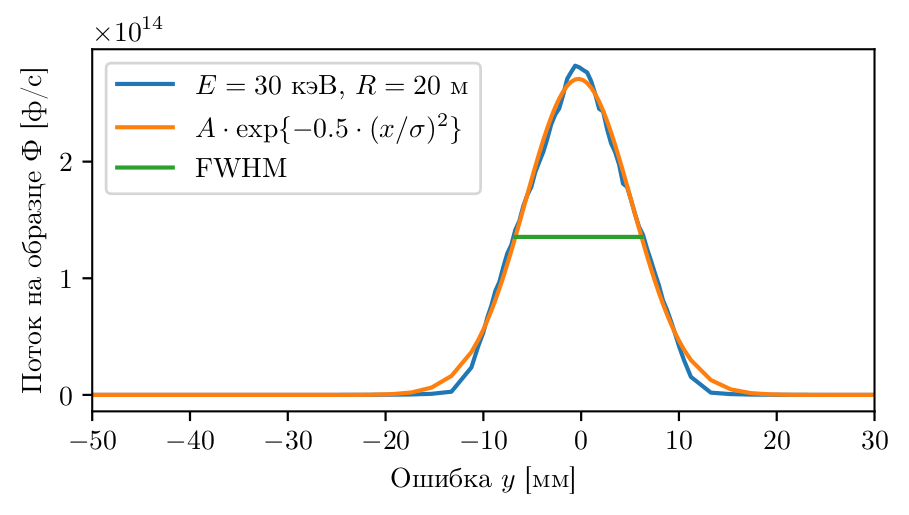

In [11]:
plt.close(fig)
fig, axes = plt.subplots()
axes.plot(xx, yy, label=r'$E = 30$ кэВ, $R = 20$ м')

popt, _ = bell_fit(xx, yy, fn='gauss')

axes.plot(xx, bell_fit.f(xx, *popt), label=r'$A \cdot \exp \{-0.5 \cdot (x/\sigma)^2\}$')
hwhm = np.sqrt(2. * np.log(2)) * popt[1]
axes.plot([popt[0] - hwhm, popt[0] + hwhm], [.5 * popt[2], .5 * popt[2]], 
          label='FWHM')
axes.set_xlim(-50, 30)

axes.set_xlabel(r'Ошибка $y$ [мм]')
axes.set_ylabel('Поток на образце Ф [ф/с]')

print('FWHM = %.01f mm' % (2. * hwhm))

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/y-offset-fit.pgf')

fig

[30.0, 90.0, 150.0] [20.0, inf]


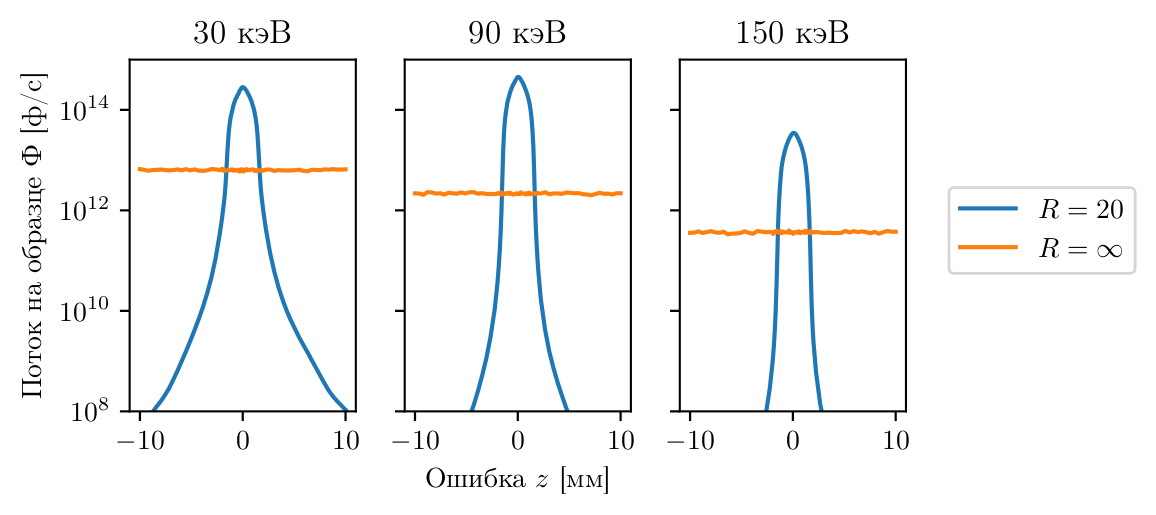

In [12]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'z_offset_scan')

flux, flux2, ebr, ebr2, r1, r2, en, dy = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dy.append(metadata['xyz_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dy = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dy)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dy_ = flux2[ii], dy[ii]
        ii = np.argsort(dy_)
        flux2_, dy_ = flux2_[ii], dy_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(dy_ * 1e-3, flux2_, label=lbl)
        
        if (en_v == 30) & (r_v == 20):
            xx, yy = dy_ * 1e-3, flux2_
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $z$ [мм]')

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/z-offset-scan.pgf')
fig

FWHM = 1.7 mm


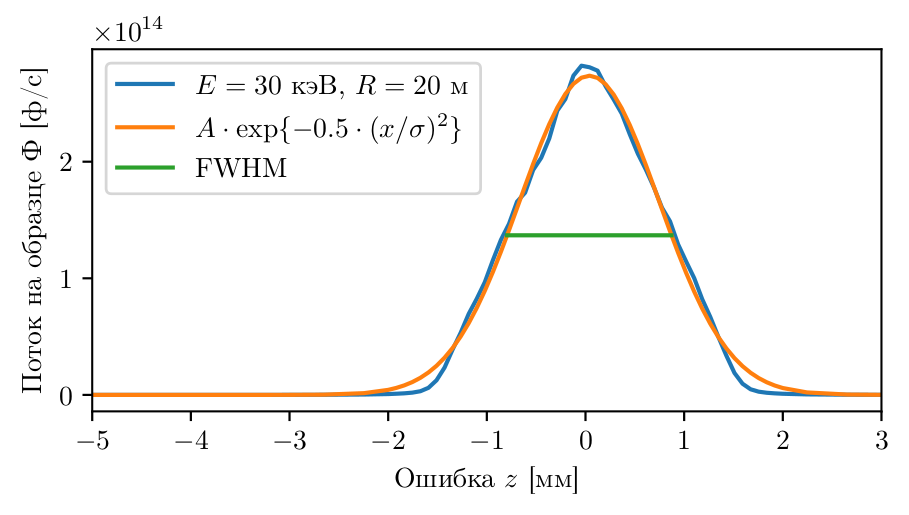

In [13]:
plt.close(fig)
fig, axes = plt.subplots()
axes.plot(xx, yy, label=r'$E = 30$ кэВ, $R = 20$ м')

popt, _ = bell_fit(xx, yy, fn='gauss')

axes.plot(xx, bell_fit.f(xx, *popt), label=r'$A \cdot \exp \{-0.5 \cdot (x/\sigma)^2\}$')
hwhm = np.sqrt(2. * np.log(2)) * popt[1]
axes.plot([popt[0] - hwhm, popt[0] + hwhm], [.5 * popt[2], .5 * popt[2]], 
          label='FWHM')
axes.set_xlim(-5, 3)

axes.set_xlabel(r'Ошибка $z$ [мм]')
axes.set_ylabel('Поток на образце Ф [ф/с]')

print('FWHM = %.01f mm' % (2. * hwhm))

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/z-offset-fit.pgf')

fig

/Users/glebdovzhenko/Yandex.Disk.localized/Dev/skif-xrt/utils/xrtutils.py:122: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum((.5 * t1d[1:] + .5 * t1d[:-1]) * (bins[1:] - bins[:-1])) / np.max(t1d)


[30.0, 90.0, 150.0] [20.0, inf]


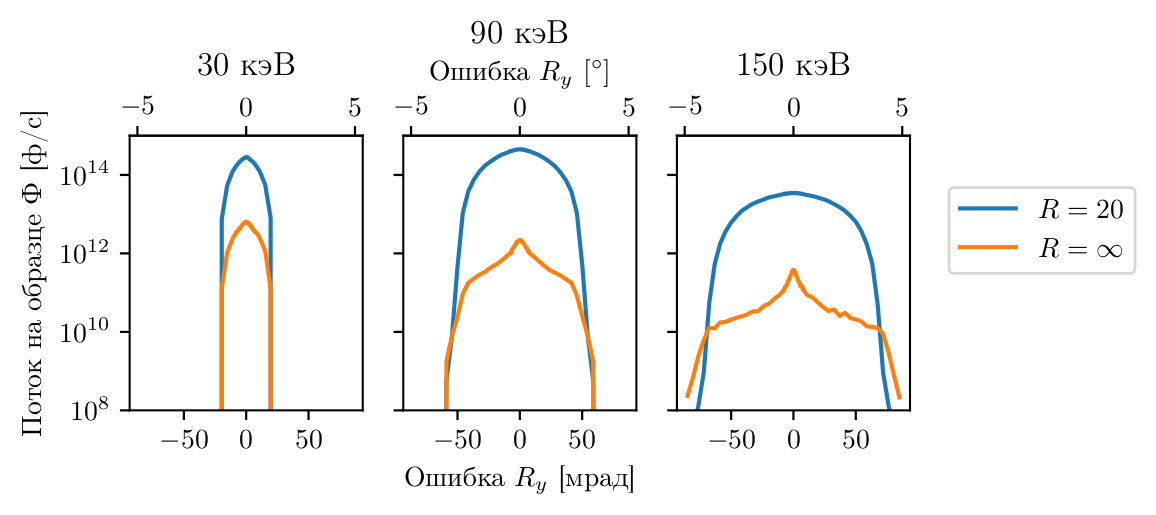

In [14]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'roll_offset_scan')

flux, flux2, ebr, ebr2, r1, r2, en, dtth = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dtth.append(metadata['tth_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dtth = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dtth)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dtth_ = flux2[ii], dtth[ii]
        ii = np.argsort(dtth_)
        flux2_, dtth_ = flux2_[ii], dtth_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(np.radians(dtth_ / 3600.) * 1e3, flux2_, label=lbl)
        
        if (en_v == 150) & np.isinf(r_v):
            xx, yy = np.radians(dtth_ / 3600.) * 1e3, flux2_
        
    secax = ax.secondary_xaxis('top', functions=(lambda x: 1e-3 * x * 180 / np.pi, lambda x: 1e3 * x  * np.pi / (180)))
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $R_y$ [мрад]')
        secax.set_xlabel(r'Ошибка $R_y$ $[^{\circ}]$')

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/roll-offset-scan.pgf')
fig

FWHM = 10.6 mrad = 0.6 deg


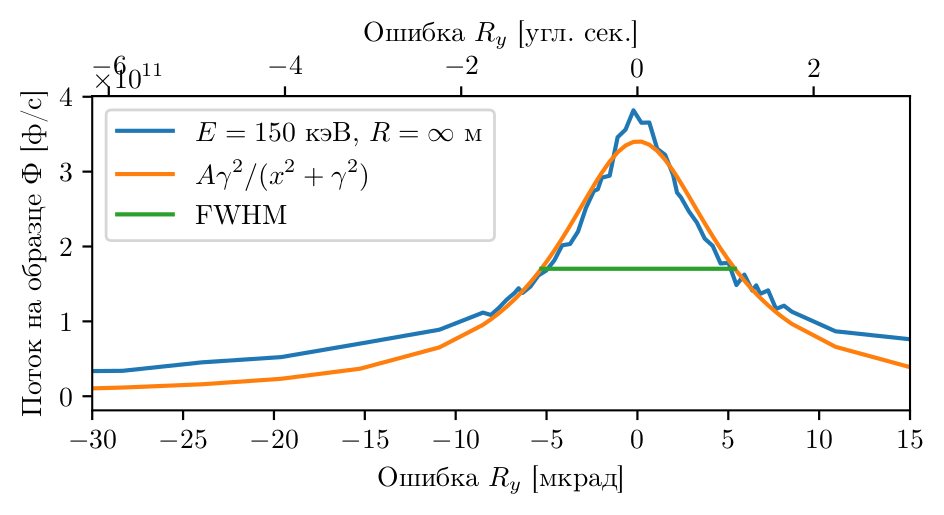

In [15]:
plt.close(fig)
fig, axes = plt.subplots()
axes.plot(xx, yy, label=r'$E = 150$ кэВ, $R = \infty$ м')

popt, _ = bell_fit(xx, yy, fn='lorentz')

axes.plot(xx, bell_fit.f(xx, *popt), label=r'$A \gamma^2 / (x^2 +\gamma^2)$')
axes.plot([popt[0] - popt[1], popt[0] + popt[1]], [.5 * popt[2], .5 * popt[2]], 
          label='FWHM')
axes.set_xlim(-30, 15)

secax = axes.secondary_xaxis('top', functions=(lambda x: 1e-6 * x * 180 * 3600 / np.pi, lambda x: 1e6 * x  * np.pi / (180 * 3600)))
axes.set_xlabel(r'Ошибка $R_y$ [мкрад]')
secax.set_xlabel(r'Ошибка $R_y$ [угл. сек.]')
axes.set_ylabel('Поток на образце Ф [ф/с]')

print('FWHM = %.01f mrad = %.01f deg' % (2. * popt[1], np.degrees(2.e-3 * popt[1])))

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/roll-offset-fit.pgf')
fig

[30.0, 90.0, 150.0] [20.0, inf]


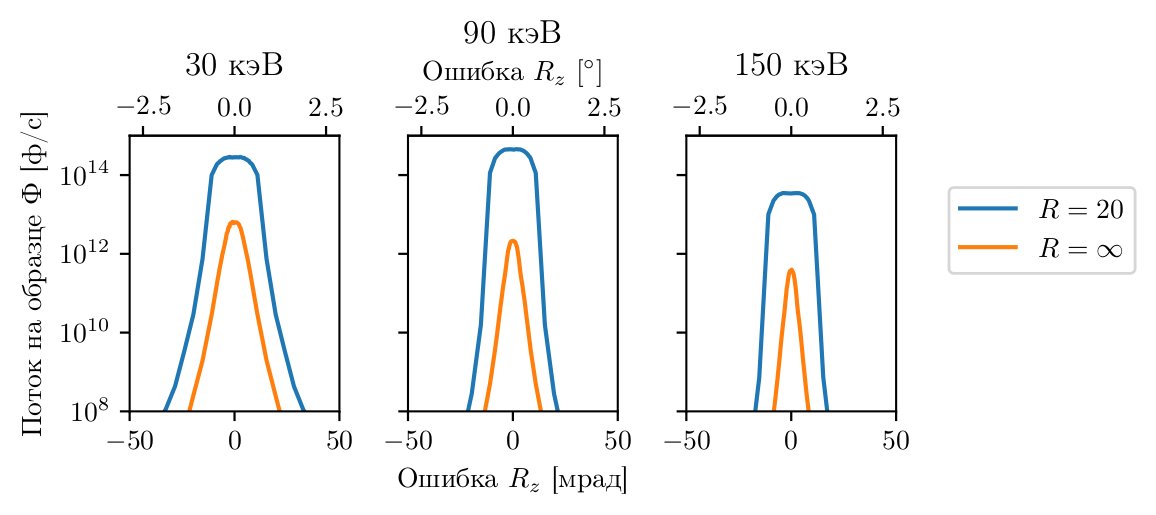

In [16]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'yaw_offset_scan')

flux, flux2, ebr, ebr2, r1, r2, en, dtth = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    if metadata['name'] != 'C1C2' or metadata['axes'] != 'XZ':
        continue

    r1.append(metadata['r1'])
    r2.append(metadata['r2'])
    en.append(metadata['energy'])
    dtth.append(metadata['tth_offset'])

    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        flux.append(data.flux)
        ebr.append(get_integral_breadth(data, axis='e'))
    
    with open(os.path.join(dd, metadata['file'].replace('C1C2', 'ES')), 'rb') as f:
        data = pickle.load(f)
        flux2.append(data.flux)
        ebr2.append(get_integral_breadth(data, axis='e'))

flux, flux2, ebr, ebr2, r1, r2, en, dtth = np.array(flux), np.array(flux2), np.array(ebr), np.array(ebr2), \
    np.array(r1), np.array(r2), np.array(en), np.array(dtth)

en_values = list(sorted(set(en)))
r1_values = list(sorted(set(r1)))
print(en_values, r1_values)

plt.close(fig)
fig, axes = plt.subplots(1, len(en_values), sharey=True)

for en_v, ax in zip(en_values, axes):
    ax.set_title('%d кэВ' % int(en_v))
    
    for r_v in r1_values:
        ii = (en == en_v) & (r1 == r_v)
        flux2_, dtth_ = flux2[ii], dtth[ii]
        ii = np.argsort(dtth_)
        flux2_, dtth_ = flux2_[ii], dtth_[ii]
        if not np.isinf(r_v):
            lbl = r'$R = %.00f$' % r_v
        else:
            lbl = r'$R = \infty$' % r_v
        if en_v != en_values[0]:
            lbl = '_' + lbl
        ax.semilogy(np.radians(dtth_ / 3600.) * 1e3, flux2_, label=lbl)
        
        if (en_v == 150) & np.isinf(r_v):
            xx, yy = np.radians(dtth_ / 3600.) * 1e3, flux2_
        
    secax = ax.secondary_xaxis('top', functions=(lambda x: 1e-3 * x * 180 / np.pi, lambda x: 1e3 * x  * np.pi / (180)))
    
    if en_v == en_values[0]:
        ax.set_ylabel('Поток на образце Ф [ф/с]')
    elif en_v == en_values[1]:
        ax.set_xlabel(r'Ошибка $R_z$ [мрад]')
        secax.set_xlabel(r'Ошибка $R_z$ $[^{\circ}]$')
    
    ax.set_xlim(-50, 50)

fig.legend(loc='right', bbox_to_anchor=(1.22, 0.55))
ax.set_ylim(10**8, 10**15)
plt.tight_layout()

plt.savefig('dcd_paper_1_figs/yaw-offset-scan.pgf')
fig

FWHM = 3.4 mrad = 0.2 deg


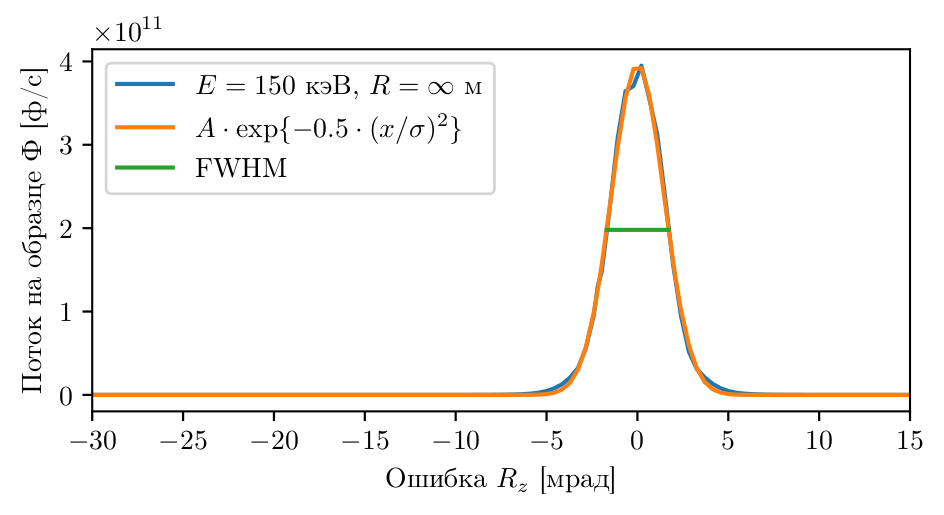

In [17]:
plt.close(fig)
fig, axes = plt.subplots()
axes.plot(xx, yy, label=r'$E = 150$ кэВ, $R = \infty$ м')

popt, _ = bell_fit(xx, yy, fn='gauss')

axes.plot(xx, bell_fit.f(xx, *popt), label=r'$A \cdot \exp \{-0.5 \cdot (x/\sigma)^2\}$')
hwhm = np.sqrt(2. * np.log(2)) * popt[1]
axes.plot([popt[0] - hwhm, popt[0] + hwhm], [.5 * popt[2], .5 * popt[2]], 
          label='FWHM')
axes.set_xlim(-30, 15)

axes.set_xlabel(r'Ошибка $R_z$ [мрад]')
axes.set_ylabel('Поток на образце Ф [ф/с]')

print('FWHM = %.01f mrad = %.01f deg' % (2. * hwhm, np.degrees(2.e-3 * hwhm)))

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/yaw-offset-fit.pgf')
fig

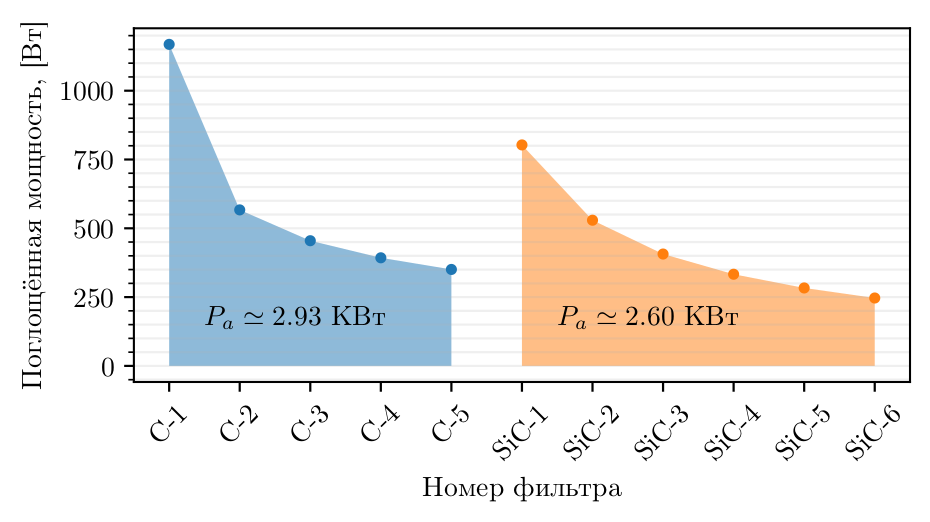

In [18]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'absorption')

filter_index, absorbed_power = [], []
for f_name in filter(lambda x: x[-7:] == '.pickle', os.listdir(dd)):
    with open(os.path.join(dd, f_name), 'rb') as f:
        data = pickle.load(f)
        f_name = f_name.split('-')[0]
        if ('F' in f_name) and ('PA' in f_name):
            filter_index.append(int(f_name.replace('F', '').replace('PA', '')))
            absorbed_power.append(data.power)
            # print(f_name, data.power)

filter_index, absorbed_power = np.array(filter_index), np.array(absorbed_power)
ii = np.argsort(filter_index)
filter_index, absorbed_power = filter_index[ii], absorbed_power[ii]

fig, axes = plt.subplots()

fi1, ap1 = filter_index[:5], absorbed_power[:5]
axes.plot(fi1, ap1, '.')
axes.fill_between(fi1, ap1, np.zeros(shape=fi1.shape), alpha=.5, linewidth=0)
fi2, ap2 = filter_index[5:], absorbed_power[5:]
axes.plot(fi2, ap2, '.')
axes.fill_between(fi2, ap2, np.zeros(shape=fi2.shape), alpha=.5, linewidth=0)

plt.xticks(ticks=np.arange(min(filter_index), max(filter_index) + 1, 1.0), 
           labels=['C-%d' % (ii + 1) for ii in range(5)] + ['SiC-%d' % (ii + 1) for ii in range(6)],
           rotation=45)
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.set_xlabel('Номер фильтра')
axes.set_ylabel('Поглощённая мощность, [Вт]')

plt.text(1.5, 150, '$P_{a} \simeq %.2f$ КВт' % np.sum(ap1 * 1e-3))
plt.text(6.5, 150, '$P_{a} \simeq %.2f$ КВт' % np.sum(ap2 * 1e-3))

plt.grid(which='both', axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig('dcd_paper_1_figs/filter_abs_power.pgf')
fig

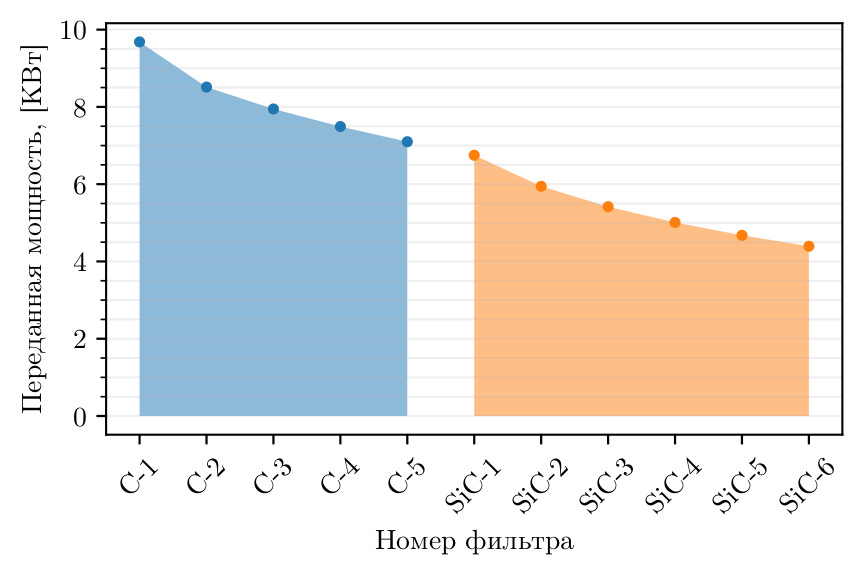

In [19]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'absorption')

filter_index, transmitted_power = [], []
for f_name in filter(lambda x: x[-7:] == '.pickle', os.listdir(dd)):
    with open(os.path.join(dd, f_name), 'rb') as f:
        data = pickle.load(f)
        f_name = f_name.split('-')[0]
        if ('F' in f_name) and (f_name[-1] == 'P'):
            filter_index.append(int(f_name.replace('F', '').replace('P', '')))
            transmitted_power.append(data.power)
            # print(f_name, data.power)

filter_index, transmitted_power = np.array(filter_index), np.array(transmitted_power)
ii = np.argsort(filter_index)
filter_index, transmitted_power = filter_index[ii], transmitted_power[ii]
transmitted_power *= 1e-3

fig, axes = plt.subplots()

fi1, tp1 = filter_index[:5], transmitted_power[:5]
axes.plot(fi1, tp1, '.')
axes.fill_between(fi1, tp1, np.zeros(shape=fi1.shape), alpha=.5, linewidth=0)
fi2, tp2 = filter_index[5:], transmitted_power[5:]
axes.plot(fi2, tp2, '.')
axes.fill_between(fi2, tp2, np.zeros(shape=fi2.shape), alpha=.5, linewidth=0)

plt.xticks(ticks=np.arange(min(filter_index), max(filter_index) + 1, 1.0), 
           labels=['C-%d' % (ii + 1) for ii in range(5)] + ['SiC-%d' % (ii + 1) for ii in range(6)],
           rotation=45)
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.set_xlabel('Номер фильтра')
axes.set_ylabel('Переданная мощность, [КВт]')

plt.grid(which='both', axis='y', alpha=0.2)
fig

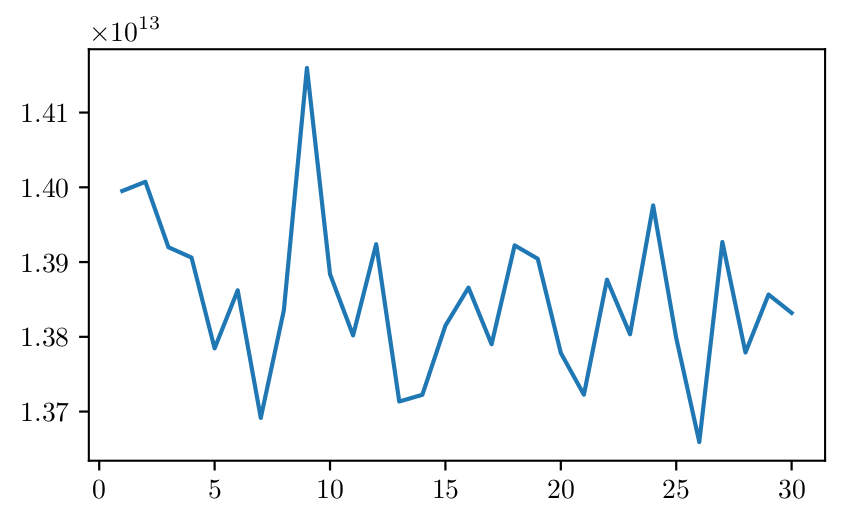

In [41]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'bump_size')

exp_n, flux = [], []
for f_name in os.listdir(dd):
    m = re.match(r'C1C2-XZ-(?P<kev>\d+)keV-front_surface(?P<expnum>\d+).pickle', f_name)
    if m is None:
        continue
    
    with open(os.path.join(dd, f_name), 'rb') as f:
        data = pickle.load(f)
        exp_n.append(float(m.groups()[1]))
        flux.append(data.flux)

exp_n, flux = np.array(exp_n), np.array(flux)
ii = np.argsort(exp_n)
exp_n, flux = exp_n[ii], flux[ii]

plt.close(fig)
fig, axes = plt.subplots()
axes.plot(exp_n, flux)
fig

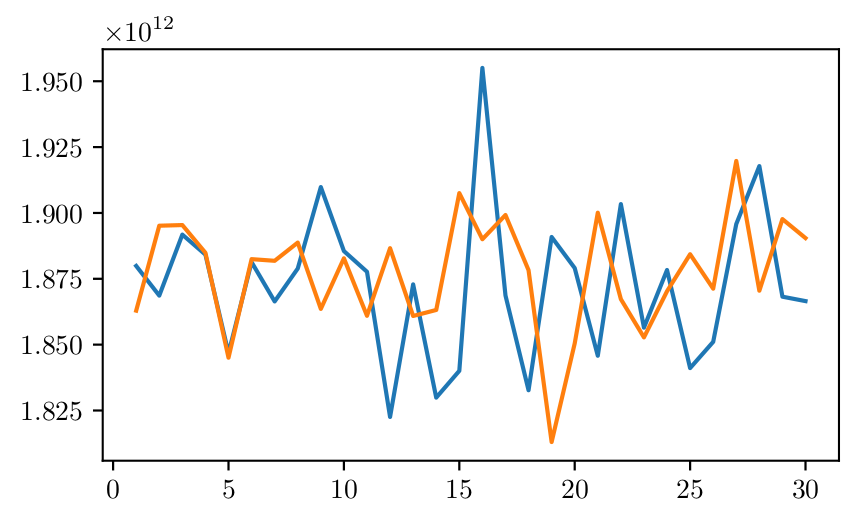

In [42]:
dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'bump_size_ref1')

exp_n1, flux1 = [], []
for f_name in os.listdir(dd):
    m = re.match(r'EM-XZ-(?P<kev>\d+)keV-front_surface(?P<expnum>\d+).pickle', f_name)
    if m is None:
        continue
    
    with open(os.path.join(dd, f_name), 'rb') as f:
        data = pickle.load(f)
        exp_n1.append(float(m.groups()[1]))
        flux1.append(data.flux)

dd = os.path.join(os.getenv('BASE_DIR'), 'datasets', 'skif15', 'bump_size_ref2')

exp_n2, flux2 = [], []
for f_name in os.listdir(dd):
    m = re.match(r'EM-XZ-(?P<kev>\d+)keV-front_surface(?P<expnum>\d+).pickle', f_name)
    if m is None:
        continue
    
    with open(os.path.join(dd, f_name), 'rb') as f:
        data = pickle.load(f)
        exp_n2.append(float(m.groups()[1]))
        flux2.append(data.flux)

exp_n1, flux1 = np.array(exp_n1), np.array(flux1)
ii = np.argsort(exp_n1)
exp_n1, flux1 = exp_n1[ii], flux1[ii]

exp_n2, flux2 = np.array(exp_n2), np.array(flux2)
ii = np.argsort(exp_n2)
exp_n2, flux2 = exp_n2[ii], flux2[ii]

plt.close(fig)
fig, axes = plt.subplots()
axes.plot(exp_n1, flux1)
axes.plot(exp_n2, flux2)
fig